# Association between omics support and target clinical success - disease-specific analysis

In [1]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

from sc_target_evidence_utils import association_utils, sc_evidence_utils
from statsmodels.stats.multitest import multipletests

In [2]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [3]:
## Get table of all genes
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
genes = ensdb.genes()

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [6]:
%%R

### Plotting utils
evidence_labels <- c(
    "all_sc_evidence" = "cell type & disease cell specific", 
    "bulk_disease_evidence" = "DE in disease (tissue)", 
    "disease_ct_evidence" = "DE in disease (cell type)", 
    "disease_evidence" = "Disease cell specific", 
    "ct_marker_evidence" = "Cell type specific", 
    "has_genetic_support" = "Genetic association"
    )

universe_labels <- c(
    'protein_coding_targets'= 'protein-coding targets',
    'sm_tractable_targets' = 'SM tractable targets',
    'ab_tractable_targets' = "Ab tractable targets",
    'known_drug_targets' = 'known drug targets\n(reached phase I)',
    'nuclear_receptors' = 'nuclear receptors', 
    'catalytic_receptors' = 'catalytic receptors', 
    'rhodop_gpcr' = 'rhodopsin-like\nGPCRs', 
    'transporters' = 'transporters', 
    'kinases' = 'kinases', 
    'enzymes' = 'enzymes', 
    'ion_channels' = 'ion channels',
    'HVGs' = 'HVGs',
    'preclinical_HVGs' = 'Preclinical HVGs'
    )


# Plot odds-ratio (no faceting)
plot_OR <- function(
    results_all_df, 
    pval_alpha=0.05, 
    base_font_size=20,
    text_position='right',
    y_value = 'clinical_status',
    evidence_levels = c('ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence', 'bulk_disease_evidence', 'has_genetic_support', 'all_sc_evidence', 'is_hvg_normal', 'is_hvg_disease'),
    clinical_status_levels = c(rev(c('druggable', 'safe', 'effective', 'approved'))),
    hide_zeros = TRUE
){
    pl_df <- results_all_df %>%
        mutate(clinical_status = factor(str_remove(clinical_status, 'is_'), levels=clinical_status_levels)) %>%
        mutate(evidence = factor(evidence, levels=evidence_levels)) %>%
        mutate(is_signif = pval < pval_alpha) %>%
        rename(setNames(y_value,'y_val')) 
    
    pl <- ggplot(pl_df, aes(y=y_val, x=odds_ratio, color=is_signif)) 
    
    if (isTRUE(hide_zeros)){
        pl <- pl +
            geom_point(
                data = . %>% filter(n_supported_approved > 0),
                size=3
            ) +
            geom_pointrange(data = . %>% filter(n_supported_approved > 0),
                            aes(xmin=ci_low, xmax=ci_high))
    } else {
        pl <- pl +
            geom_point(size=3) +
            geom_pointrange(aes(xmin=ci_low, xmax=ci_high))}
        
    pl <- pl + geom_text(aes(label = paste0(n_supported_approved,' / ', n_success)), 
                      x = ifelse(text_position == 'right', Inf, -Inf) , 
                      hjust= ifelse(text_position == 'right', 1.1, -1) , 
                      size=5,
                      color='black',) +
        geom_vline(xintercept=1, linetype=2) +
        scale_x_log10(labels = scales::label_number()) +
        xlab('Odds Ratio') +
        ylab(y_value) +
        theme_classic(base_size=base_font_size) +
        scale_color_manual(values=c('TRUE' = 'red', 'FALSE'='grey50'), 
                           name=paste0("Significant enrichment\n(Fisher's test p-value < ", round(pval_alpha, digits=2), ')')) +
        theme(strip.text.y=element_text(angle=0), strip.background = element_rect(color=NA, fill = "grey"))    
    pl
}

In [10]:
figdir = '/home/jovyan/mount/gdrive/sc_targetID/plots/association_results_nelson/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

## Get single-cell support from DE results and merge with OT evidence 

In [149]:
def _parse_DE(
    disease_ontology_id, 
    OT_targets_df,
    signif_thresh = 0.01,
    DE2evidence_celltype_params = {"lfc_thresh":5.0, 'ct_fraction_thresh':1.0},
    DE2evidence_disease_params = {"lfc_thresh":0.5, 'lfc_group':'positive'},
    data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
    ):
    '''Parse DE outputs for each disease and merge with OT clinical status and genetic evidence.
    
    Params
    ------
    disease_ontology_id
        Disease MONDO ID
    OT_targets_df
        Dataframe of OpenTargets target-disease pairs
    signif_thresh
        Threshold for DE adjusted p-value
    DE2evidence_celltype_params
        parameters passed to `DE2evidence_celltype_params`
    DE2evidence_disease_params
        parameters passed to `DE2evidence_disease_params`
    data_dir 
        path to directory storing DE results
        
    Returns
    -------
    targets_disease_df
        DataFrame of target-disease pairs with clinical status and omics evidence.
    '''
    ct_res = pd.read_csv(f'{data_dir}/DE_celltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    disease_res = pd.read_csv(f'{data_dir}/DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    bulk_res = pd.read_csv(f'{data_dir}/DE_diseasebulk_{disease_ontology_id.replace(":","_")}.hvgs.csv')

    evidence_dict = sc_evidence_utils.DE2evidence_celltype(
        ct_res, signif_thresh=signif_thresh, **DE2evidence_celltype_params)
    disease_evidence = sc_evidence_utils.DE2evidence_disease(
        disease_res, bulk_res,  signif_thresh=signif_thresh, **DE2evidence_disease_params)
    evidence_dict.update(disease_evidence)
    evidence_dict['is_hvg_normal'] = ct_res.gene_id.unique()
    evidence_dict['is_hvg_disease'] = disease_res.gene_id.unique()
    # Make target-disease table for sc evidence
    targets_disease_df = pd.DataFrame()
    targets_disease_df['gene_id'] = np.unique(np.hstack([x for x in evidence_dict.values()])) # Get all targets with sc evidence
    targets_disease_df['disease_ontology_id'] = disease_ontology_id

    for ev,targets in evidence_dict.items():
        targets_disease_df[ev] = targets_disease_df.gene_id.isin(targets).astype(int)
    
    # Merge with Open Targets clinical status and genetic evidence
    OT_targets_disease_df = OT_targets_df[
        (OT_targets_df['disease_ontology_id'] == disease_ontology_id) & \
        ((OT_targets_df['known_drug'] > 0) | (OT_targets_df['has_genetic_support'] > 0)) 
    ].copy()

    targets_disease_df = pd.merge(OT_targets_disease_df, targets_disease_df, how='outer').fillna(0)
    return(targets_disease_df)

In [572]:
## Get all disease IDs
all_pbulk_files = [x for x in os.listdir(data_dir) if x.endswith('pbulk_all_genes.h5ad')]
all_disease_ids = [x.replace('.pbulk_all_genes.h5ad', '').replace('cellxgene_targets_', '') for x in all_pbulk_files]
all_disease_ids = [x for x in all_disease_ids if x.startswith("MONDO")]

In [598]:
## Save evidence results for each disease
targets_evidence_all = pd.DataFrame()
for disease_ontology_id in all_disease_ids:
    try:
        targets_disease_df = _parse_DE(
            disease_ontology_id, 
            OT_targets_df,
            signif_thresh = 0.01,
            DE2evidence_celltype_params = {"lfc_thresh":5.0, 'ct_fraction_thresh':1.0},
            DE2evidence_disease_params = {"lfc_thresh":0.5, 'lfc_group':'positive'}
        )
    except FileNotFoundError:
        print(f'missing {disease_ontology_id}')
        continue
    targets_disease_df['disease'] = disease_name_mapper[disease_ontology_id.replace('_', ":")]
    targets_disease_df['disease_relevant_tissue'] = disease_tissue_mapper[disease_ontology_id.replace('_', ":")]
    targets_evidence_all = pd.concat([targets_evidence_all, targets_disease_df], axis=0)
    targets_disease_df.to_csv(data_dir + f'disease_target_evidence.{disease_ontology_id}.csv')

targets_evidence_all['any'] = (targets_evidence_all[['ct_marker_evidence', 'disease_ct_evidence', 'has_genetic_support']].sum(1) > 0).astype('int')

missing MONDO_0005575
missing MONDO_0024661
missing MONDO_0006156
missing MONDO_0006249
missing MONDO_0012883
missing MONDO_0018874
missing MONDO_0001056
missing MONDO_0024885
missing MONDO_0024660


annotate target class

In [884]:
targets_evidence_all = pd.merge(targets_evidence_all, ens_ids_to_name, how='left')
for k,a in annos.items():
    targets_evidence_all[f'is_{k}'] = targets_evidence_all.gene_name.isin(a).astype('int')

gene_group_cols = [f'is_{k}' for k in annos.keys()]
targets_evidence_all['gene_class'] = np.where(
    targets_evidence_all[gene_group_cols].sum(1) > 0,
    targets_evidence_all[gene_group_cols].idxmax(axis=1).str.replace('is_', ''),
    'other'
        )
    

In [890]:
targets_evidence_all.to_csv(data_dir + 'disease_target_evidence.all.csv')

### Parse DE analysis results

In [126]:
targets_evidence_all = pd.read_csv('../data/disease_target_evidence.all.csv', index_col=0)

In [127]:
evidence_table = targets_evidence_all[['gene_id','gene_name', 'disease', 'disease_ontology_id',
                                       'ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence', 'bulk_disease_evidence','has_genetic_support',
                                       'is_hvg_normal', 'is_hvg_disease'
                                      ]]
evidence_table.rename({'has_genetic_support':'genetic_evidence_OT'}, axis=1, inplace=True)

ot_target_table = targets_evidence_all[['gene_id', 'disease_ontology_id', 'disease', 'known_drug']].copy()
ot_target_table['succ_1_2'] = np.where(ot_target_table['known_drug'] > 0.1, True, False)
ot_target_table['succ_2_3'] = np.where(ot_target_table['known_drug'] > 0.2, True, False)
ot_target_table['succ_3_a'] = np.where(ot_target_table['known_drug'] > 0.7, True, False)



/tmp/ipykernel_199/3473263480.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evidence_table.rename({'has_genetic_support':'genetic_evidence_OT'}, axis=1, inplace=True)


### Merge with clinical success evidence - Filtered pharmaprojects from Minikel et al. 2024

In [35]:
def _get_ti_pair_tissue_evidence(ti_pair):
        dtr_evidence = ti_pair[['ct_marker_evidence_' + x.replace(' ', '_') for x in ti_pair['disease_relevant_tissues']]]
        if dtr_evidence.isna().all(): # Keep only HVGs
            return(np.nan)
        else:
            if dtr_evidence.sum() > 0:
                return 1
            else:
                return 0
    
def merge_evidence_success(
    ct_targets_wide_df, 
    nelson_targets_df, 
    ev='ct_marker_evidence',
    keep_nelson_cols = ['ti_uid', 'indication_mesh_term', 'gene_id', 'gene_name','combined_max_phase','target_status', 'disease_relevant_tissues'],
    how = 'left'
):
    all_scrnaseq_tissues = ct_targets_wide_df.set_index('gene_id').columns.str.replace(f'{ev}_', '').tolist()
    dtr_cols = nelson_targets_df.columns[nelson_targets_df.columns.str.startswith("dtr_")].tolist()
    
    tissues_all_df = nelson_targets_df[keep_nelson_cols + success_cols + dtr_cols]
    ti_no = tissues_all_df.shape[0]
    tissues_all_df = pd.merge(tissues_all_df, ct_targets_wide_df, how=how)
    
    tissues_all_df['disease_relevant_tissues'] = tissues_all_df['disease_relevant_tissues'].str.split(",")
    tissues_all_df['disease_relevant_tissues'] = [np.intersect1d(x, all_scrnaseq_tissues).tolist() for x in tissues_all_df['disease_relevant_tissues']]
    if how == 'left':
        # Keep T-I pairs with at least one tissue measured with scRNA-seq
        tissues_all_df = tissues_all_df[[len(x)>0 for x in tissues_all_df['disease_relevant_tissues']]].copy()
        tissues_all_df[ev] = tissues_all_df.apply(_get_ti_pair_tissue_evidence, axis=1)
        tissues_all_df.drop(ct_targets_wide_df.set_index('gene_id').columns, axis=1, inplace=True)
        assert tissues_all_df.ti_uid.is_unique
        assert not any(tissues_all_df.combined_max_phase.isna())
    else:
        assert ct_targets_wide_df.shape[1] == 2
        tissues_all_df[ev] = tissues_all_df[ct_targets_wide_df.set_index('gene_id').columns[0]]
        tissues_all_df.drop(ct_targets_wide_df.set_index('gene_id').columns, axis=1, inplace=True)
        assert tissues_all_df.gene_id.nunique() <= 5000
#     tissues_all_df['disease_relevant_tissues'] = [x[0] for x in tissues_all_df['disease_relevant_tissues']]
    return(tissues_all_df)

Read Minikel et al. table

In [36]:
cr_df = pd.read_csv('../data/nelson_s01_cross_references.csv', encoding='cp1252', index_col=0)
keep_columns = ['ti_uid','indication_mesh_id', 'indication_mesh_term','target', 'combined_max_phase', 'succ_p_1', 'succ_1_2',
       'succ_2_3', 'succ_3_a', 'target_status', 'MONDO'] 
rename_columns = {
    'target':'gene_name',
    'dtr_retina':'dtr_eye'
}

nelson_targets_df = cr_df[keep_columns].copy()
nelson_targets_df = nelson_targets_df.rename(rename_columns, axis=1)
dtr_cols = nelson_targets_df.columns[nelson_targets_df.columns.str.startswith('dtr_')]

genes = ensdb.genes(cols=["gene_id", "gene_name"])

## Add gene ids
genes = genes.groupby('gene_name').first()

shared_names = np.intersect1d(genes.index, nelson_targets_df.gene_name)
missing_names = np.setdiff1d(nelson_targets_df.gene_name, shared_names)

rename_missing_names = {
    'TMEM173':'STING1',
    'ACPP':'ACP3',
    'COL4A3BP':'CERT1',
    'G6PC':'G6PC1',
    'H3F3A':'H3-3A',
    'HARS':'HARS1',
    'HIST1H1C':'H1-2',
    'HIST1H1D':'H1-3',
    'HIST1H1E':'H1-4',
    'KARS':'KARS1',
    'PHB':'PHB1',
    'QARS':'QARS1',
    'RARRES3':'PLAAT4', 
    }

nelson_targets_df['gene_name'] = [rename_missing_names[x] if x in rename_missing_names.keys() else x for x in nelson_targets_df.gene_name]

nelson_targets_df = pd.merge(nelson_targets_df, genes, on='gene_name', how='left')

## Annotate genetic evidence (indirect, as Minikel et al.)
nelson_targets_df['genetic_evidence_minikel'] = (nelson_targets_df['target_status'] == 'genetically supported target').astype(int)

In [54]:
## Read mapping of diseases to MeSH IDs
all_diseases = pd.read_csv('../data/all_diseases_postqc.csv', index_col=0)
all_diseases.indication_mesh_term.nunique()

25

In [55]:
all_diseases

,disease_ontology_id,disease,indication_mesh_term,indication_mesh_id
0,MONDO_0005097,squamous cell lung carcinoma,"Carcinoma, Squamous Cell",D002294
14806,MONDO_0004298,stomach disorder,Gastroesophageal Reflux,D005764
29810,MONDO_0004514,chronic rhinitis,Rhinitis,D012220
45154,MONDO_0005249,pneumonia,Pneumonia,D011014
57249,MONDO_0005011,Crohn disease,Crohn Disease,D003424
73838,MONDO_0005300,chronic kidney disease,"Kidney Failure, Chronic",D007676
85793,MONDO_0005068,myocardial infarction,Myocardial Infarction,D009203
100391,MONDO_0002771,pulmonary fibrosis,Idiopathic Pulmonary Fibrosis,D054990
114516,MONDO_0015925,interstitial lung disease,"Lung Diseases, Interstitial",D017563
128689,MONDO_0018906,follicular lymphoma,"Lymphoma, Follicular",D008224


In [128]:
# show diseases excluded because of no match in Minikel et al. table
all_diseases[all_diseases.indication_mesh_term.isna()].disease

251895         B-cell non-Hodgkin lymphoma
320109                      adenocarcinoma
332687                 lung adenocarcinoma
375948                       Crohn ileitis
402682    common variable immunodeficiency
Name: disease, dtype: object

In [131]:
disease_evidence_all['ct_marker_evidence'].sum()

27780.0

In [132]:
disease_evidence_all['disease_evidence'].sum()

49253.0

In [57]:
## Filter diseases and add MONDO ontology IDs
nelson_targets_df = nelson_targets_df[nelson_targets_df.indication_mesh_id.isin(all_diseases.indication_mesh_id.unique())]
nelson_targets_df = pd.merge(nelson_targets_df, all_diseases[['disease_ontology_id', 'disease','indication_mesh_id']], how='left')

In [107]:
success_cols = ['succ_p_1', 'succ_1_2', 'succ_2_3', 'succ_3_a']
disease_evidence_all = pd.merge(evidence_table, nelson_targets_df, how='left')
disease_evidence_all = disease_evidence_all[disease_evidence_all.disease_ontology_id.isin(all_diseases.dropna().disease_ontology_id.unique())]
# Mark missing omic evidence
disease_evidence_all['ct_marker_evidence'] = disease_evidence_all['ct_marker_evidence'].fillna(0)
disease_evidence_all['disease_evidence'] = disease_evidence_all['disease_evidence'].fillna(0)
disease_evidence_all['disease_ct_evidence'] = disease_evidence_all['disease_ct_evidence'].fillna(0)
disease_evidence_all['bulk_disease_evidence'] = disease_evidence_all['bulk_disease_evidence'].fillna(0)
disease_evidence_all['genetic_evidence_OT'] = disease_evidence_all['genetic_evidence_OT'].fillna(0)
# Mark missing clinical success evidence
disease_evidence_all[success_cols] = disease_evidence_all[success_cols].fillna(False)

In [108]:
nelson_targets_df.shape

(2663, 15)

In [109]:
nelson_targets_df[success_cols].sum()

succ_p_1    1648
succ_1_2    1208
succ_2_3     336
succ_3_a     145
dtype: object

In [110]:
## Select universes of genes
hvgs_df = disease_evidence_all[disease_evidence_all.is_hvg_normal==1].copy()
prec_df = disease_evidence_all[(~disease_evidence_all.ti_uid.isna())].copy()
prec_hvgs_df = disease_evidence_all[(~disease_evidence_all['combined_max_phase'].isna()) & (disease_evidence_all.is_hvg_normal==1)].copy()

In [111]:
# Save for sharing
hvgs_df.to_csv('../data/disease_specific_analysis.target_disease_table.all_hvgs_ct_specific.csv')
prec_hvgs_df.to_csv('../data/disease_specific_analysis.target_disease_table.preclinical_hvgs_ct_specific.csv')

In [112]:
hvgs_df[success_cols] = hvgs_df[success_cols].fillna(False)
hvgs_df[success_cols] = hvgs_df[success_cols].astype(int)

prec_df[success_cols] = prec_df[success_cols].fillna(False)
prec_df[success_cols] = prec_df[success_cols].astype(int)

prec_hvgs_df[success_cols] = prec_hvgs_df[success_cols].fillna(False)
prec_hvgs_df[success_cols] = prec_hvgs_df[success_cols].astype(int)


results_disease_df = pd.DataFrame()
for ph in success_cols:
    for ev in ['ct_marker_evidence', 'genetic_evidence_OT', 'genetic_evidence_minikel']:
        or_df = association_utils.get_OR(
            hvgs_df[~hvgs_df[ph].isna()],  # universe HVGs
            evidence_col = ev, clinical_status_col=ph)
        or_df['universe'] = 'HVGs'
        results_disease_df = pd.concat([results_disease_df, or_df], axis=0)
        or_df = association_utils.get_OR(
            prec_hvgs_df[~prec_hvgs_df[ph].isna()],  # universe preclinical HVGs
            evidence_col = ev, clinical_status_col=ph)
        or_df['universe'] = 'active_HVGs'
        results_disease_df = pd.concat([results_disease_df, or_df], axis=0)
        
sig, fdr, _,_ = multipletests(results_disease_df.pval, method='fdr_bh')
results_disease_df['pval'] = fdr

evidence_labels = {
    'disease_evidence':'Disease cell specific',
    'ct_marker_evidence':'Cell type specific',
    'genetic_evidence_minikel':'Genetic evidence\n(Minikel et al.)',
    'genetic_evidence_OT':'Genetic evidence\n(Open Targets)'
}

succ2maxphase = {
    'succ_p_1':'Phase I',
    'succ_1_2':'Phase II',
    'succ_2_3':'Phase III',
    'succ_3_a':'Launched',
}

results_disease_df['clinical_status'] = results_disease_df['clinical_status'].map(succ2maxphase)
results_disease_df['evidence'] = results_disease_df['evidence'].map(evidence_labels)

In [113]:
results_disease_df.to_csv('../data/disease_specific_analysis.OR_results.cell_type_specific.csv')
results_disease_df

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,universe
0,2.154422,1.874453,2.473341,4.302824e-25,888.0,124112.0,337.0,27780.0,Cell type specific,Phase I,HVGs
0,1.430737,1.126991,1.820386,3.839546e-03,888.0,511.0,337.0,490.0,Cell type specific,Phase I,active_HVGs
0,3.903041,2.756854,5.385576,2.843803e-11,888.0,124112.0,40.0,1522.0,Genetic evidence\n(Open Targets),Phase I,HVGs
0,0.661968,0.402500,1.094025,9.667092e-01,888.0,511.0,40.0,74.0,Genetic evidence\n(Open Targets),Phase I,active_HVGs
0,0.949789,0.578121,1.584383,7.868408e-01,888.0,124112.0,48.0,77.0,Genetic evidence\n(Minikel et al.),Phase I,HVGs
0,0.949789,0.578121,1.584383,7.868408e-01,888.0,511.0,48.0,77.0,Genetic evidence\n(Minikel et al.),Phase I,active_HVGs
0,2.272847,1.936579,2.663826,3.786359e-22,665.0,124335.0,261.0,27780.0,Cell type specific,Phase II,HVGs
0,1.424310,1.135763,1.787146,2.948195e-03,665.0,734.0,261.0,490.0,Cell type specific,Phase II,active_HVGs
0,3.751620,2.483232,5.463923,3.875744e-08,665.0,124335.0,29.0,1522.0,Genetic evidence\n(Open Targets),Phase II,HVGs
0,0.698325,0.416726,1.154122,9.667092e-01,665.0,734.0,29.0,74.0,Genetic evidence\n(Open Targets),Phase II,active_HVGs


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


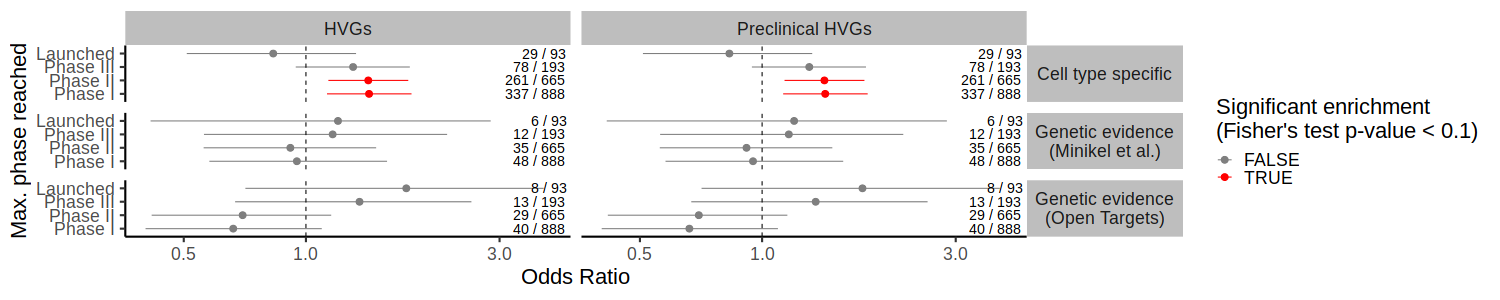

In [28]:
%%R -i results_disease_df -w 1500 -h 300 -i figdir

pl_df <- results_disease_df 
plot_OR(pl_df, y_value='clinical_status',
        text_position='right', pval_alpha=0.1,
        evidence_levels=c('Cell type specific', 'Genetic evidence\n(Minikel et al.)', 'Genetic evidence\n(Open Targets)'),
        clinical_status_levels = c('Phase I','Phase II', 'Phase III', 'Launched'),
               base_font_size=22
       ) +
    facet_grid(evidence~universe, scales='free_x', labeller = labeller(universe=as_labeller(universe_labels))) +
    ylab("Max. phase reached") +
    expand_limits(x=4) 

# ggsave(paste0(figdir, 'disease_specific_analysis.ct_specific.all.pdf'), width=16, height=6)

In [114]:
## Select universes of genes
for c in success_cols:
    disease_evidence_all.loc[~disease_evidence_all[c].isna(), c] = disease_evidence_all.loc[~disease_evidence_all[c].isna(), c].astype(int)
hvgs_df = disease_evidence_all[disease_evidence_all.is_hvg_disease==1].copy()
prec_df = disease_evidence_all[(~disease_evidence_all.ti_uid.isna())].copy()
prec_hvgs_df = disease_evidence_all[(~disease_evidence_all['combined_max_phase'].isna()) & (disease_evidence_all.is_hvg_disease==1)].copy()

In [115]:
# Save for sharing
hvgs_df.to_csv('../data/disease_specific_analysis.target_disease_table.all_hvgs_dc_specific.csv')
prec_hvgs_df.to_csv('../data/disease_specific_analysis.target_disease_table.preclinical_hvgs_dc_specific.csv')

In [116]:
hvgs_df[success_cols] = hvgs_df[success_cols].fillna(False)
hvgs_df[success_cols] = hvgs_df[success_cols].astype(int)

prec_df[success_cols] = prec_df[success_cols].fillna(False)
prec_df[success_cols] = prec_df[success_cols].astype(int)

prec_hvgs_df[success_cols] = prec_hvgs_df[success_cols].fillna(False)
prec_hvgs_df[success_cols] = prec_hvgs_df[success_cols].astype(int)


In [120]:
results_disease_df = pd.DataFrame()
for ph in success_cols:
    for ev in ['disease_evidence', 'genetic_evidence_OT', 'genetic_evidence_minikel']:
        or_df = association_utils.get_OR(
            hvgs_df[~hvgs_df[ph].isna()],  # universe HVGs
            evidence_col = ev, clinical_status_col=ph)
        or_df['universe'] = 'HVGs'
        results_disease_df = pd.concat([results_disease_df, or_df], axis=0)
        or_df = association_utils.get_OR(
            prec_hvgs_df[~prec_hvgs_df[ph].isna()],  # universe preclinical HVGs
            evidence_col = ev, clinical_status_col=ph)
        or_df['universe'] = 'active_HVGs'
        results_disease_df = pd.concat([results_disease_df, or_df], axis=0)

sig, fdr, _,_ = multipletests(results_disease_df.pval, method='fdr_bh')
results_disease_df['pval'] = fdr
results_disease_df['clinical_status'] = results_disease_df['clinical_status'].map(succ2maxphase)
results_disease_df['evidence'] = results_disease_df['evidence'].map(evidence_labels)

In [121]:
results_disease_df.to_csv('../data/disease_specific_analysis.OR_results.disease_cell_specific.csv')
results_disease_df

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,universe
0,1.921422,1.697385,2.170777,3.454862e-22,1436.0,342688.0,348.0,49253.0,Disease cell specific,Phase I,HVGs
0,1.024761,0.837426,1.255795,5.965476e-01,1436.0,866.0,348.0,554.0,Disease cell specific,Phase I,active_HVGs
0,4.945587,3.744033,6.423638,3.571411e-21,1436.0,342688.0,60.0,3055.0,Genetic evidence\n(Open Targets),Phase I,HVGs
0,0.855541,0.561444,1.313929,8.415491e-01,1436.0,866.0,60.0,102.0,Genetic evidence\n(Open Targets),Phase I,active_HVGs
0,1.037780,0.682051,1.597705,5.965476e-01,1436.0,342688.0,67.0,106.0,Genetic evidence\n(Minikel et al.),Phase I,HVGs
0,1.037780,0.682051,1.597705,5.965476e-01,1436.0,866.0,67.0,106.0,Genetic evidence\n(Minikel et al.),Phase I,active_HVGs
0,1.935396,1.674407,2.231099,2.347544e-17,1054.0,343070.0,257.0,49253.0,Disease cell specific,Phase II,HVGs
0,1.032507,0.848243,1.256340,5.852105e-01,1054.0,1248.0,257.0,554.0,Disease cell specific,Phase II,active_HVGs
0,5.157354,3.743060,6.948621,2.347544e-17,1054.0,343070.0,46.0,3055.0,Genetic evidence\n(Open Targets),Phase II,HVGs
0,0.971384,0.636954,1.475115,6.496382e-01,1054.0,1248.0,46.0,102.0,Genetic evidence\n(Open Targets),Phase II,active_HVGs


In [361]:
%%R -i results_disease_df -w 1500 -h 300 -i figdir
pl_df <- results_disease_df 
plot_OR(pl_df, y_value='clinical_status',
        text_position='right', pval_alpha=0.1,
        evidence_levels=c('Disease cell specific', 'Genetic evidence\n(Minikel et al.)', 'Genetic evidence\n(Open Targets)'),
        clinical_status_levels = c('Phase I','Phase II', 'Phase III', 'Launched'),
               base_font_size=22
       ) +
    facet_grid(evidence~universe, scales='free_x', labeller = labeller(universe=as_labeller(universe_labels))) +
    ylab("Omic support") +
    expand_limits(x=4) 
    
ggsave(paste0(figdir, 'disease_specific_analysis.disease_specific.all.pdf'), width=16, height=6)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [125]:
ct_test_results = pd.read_csv('../data/disease_specific_analysis.OR_results.cell_type_specific.csv', index_col=0)
ct_test_results['test'] = 'Cell type specific test'
dc_test_results = pd.read_csv('../data/disease_specific_analysis.OR_results.disease_cell_specific.csv', index_col=0)
dc_test_results['test'] = 'Disease cell specific test'
pd.concat([ct_test_results, dc_test_results], axis=0).to_csv('../data/suppl_table_4.disease_specific_analysis.odds_ratios.csv')

## Progression analysis

In [362]:
## Select universes of genes
for c in success_cols:
    disease_evidence_all.loc[~disease_evidence_all[c].isna(), c] = disease_evidence_all.loc[~disease_evidence_all[c].isna(), c].astype(int)
prec_df = disease_evidence_all[(~disease_evidence_all.ti_uid.isna())].copy()

In [363]:
results_disease_df = pd.DataFrame()
for ph in success_cols[1:]:
    for ev in ['ct_marker_evidence', 'disease_evidence', 'genetic_evidence_OT', 'genetic_evidence_minikel']:
        or_df = association_utils.get_OR(
            prec_df[~prec_df[ph].isna()],  # universe preclinical HVGs
            evidence_col = ev, clinical_status_col=ph)
        or_df['universe'] = 'preclinical'
        results_disease_df = pd.concat([results_disease_df, or_df], axis=0)

sig, fdr, _,_ = multipletests(results_disease_df.pval, method='fdr_bh')
results_disease_df['pval'] = fdr

In [364]:
succ2maxphase = {
    'succ_1_2':'Phase I to II',
    'succ_2_3':'Phase II to III',
    'succ_3_a':'Phase III to Launch',
}

results_disease_df['clinical_status'] = results_disease_df['clinical_status'].map(succ2maxphase)
results_disease_df['evidence'] = results_disease_df['evidence'].map(evidence_labels)
results_disease_df

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,universe
0,1.392086,1.135376,1.707676,0.007865,1123.0,1282.0,261.0,490.0,Cell type specific,Phase I to II,preclinical
0,0.984233,0.809735,1.195871,0.778445,1123.0,1282.0,257.0,554.0,Disease cell specific,Phase I to II,preclinical
0,0.897799,0.598692,1.340090,0.808713,1123.0,1282.0,49.0,111.0,Genetic evidence\n(Open Targets),Phase I to II,preclinical
0,0.913259,0.608203,1.365344,0.808713,1123.0,1282.0,49.0,110.0,Genetic evidence\n(Minikel et al.),Phase I to II,preclinical
0,1.327453,0.992100,1.762580,0.113329,317.0,2088.0,78.0,490.0,Cell type specific,Phase II to III,preclinical
0,1.240976,0.935479,1.635051,0.204650,317.0,2088.0,84.0,554.0,Disease cell specific,Phase II to III,preclinical
0,1.291252,0.722583,2.192682,0.346005,317.0,2088.0,18.0,111.0,Genetic evidence\n(Open Targets),Phase II to III,preclinical
0,1.305934,0.730484,2.218834,0.346005,317.0,2088.0,18.0,110.0,Genetic evidence\n(Minikel et al.),Phase II to III,preclinical
0,1.042271,0.658385,1.605186,0.688821,138.0,2267.0,29.0,490.0,Cell type specific,Phase III to Launch,preclinical
0,0.584036,0.344922,0.946029,0.992735,138.0,2267.0,21.0,554.0,Disease cell specific,Phase III to Launch,preclinical


In [365]:
%%R -i results_disease_df -w 1000 -h 600 -i figdir
pl_df <- results_disease_df 
plot_OR(pl_df, y_value='clinical_status',
        text_position='right', 
        evidence_levels=c('Cell type specific','Disease cell specific', 'Genetic evidence\n(Minikel et al.)', 'Genetic evidence\n(Open Targets)'),
        clinical_status_levels = c('Phase I to II', 'Phase II to III', 'Phase III to Launch'),
        base_font_size=22,
        pval_alpha=0.1
       ) +
    facet_grid(evidence~., scales='free_x'
#                labeller = labeller(
#                    universe=as_labeller(uni_labeller)
              ) +
    ylab("Omic support") +
    expand_limits(x=4) 
    
ggsave(paste0(figdir, 'disease_specific_analysis.progression.all.pdf'), width=16, height=6)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


## Test by disease

In [366]:
keep_diseases = prec_df.value_counts('disease').index[prec_df.value_counts('disease') > 20].tolist()
results_bydisease_df = association_utils.compute_grouped_OR(
    prec_df[prec_df.disease.isin(keep_diseases)], 
    group_by='disease', 
    evidence_cols=['disease_evidence', 'ct_marker_evidence', 'genetic_evidence_minikel', 'genetic_evidence_OT'],
    clinical_status_cols=success_cols[1:])

sig, fdr, _,_ = multipletests(results_bydisease_df.pval, method='fdr_bh')
results_bydisease_df['pval'] = fdr

In [367]:
results_bydisease_df['clinical_status'] = results_bydisease_df['clinical_status'].map(succ2maxphase)
results_bydisease_df['evidence'] = results_bydisease_df['evidence'].map(evidence_labels)

In [138]:
%%R -i results_bydisease_df -w 1500 -h 400 -i figdir
pl_df <- filter(results_bydisease_df, evidence == 'Cell type specific') 

# Order by OR for ct markers
disease_order <- filter(pl_df, clinical_status == 'Phase I to II') %>% arrange(odds_ratio) %>% pull(disease)
pl_df <- mutate(pl_df, disease=factor(disease, levels=disease_order))

plot_OR(pl_df, y_value='disease',
        text_position='right', 
        evidence_levels=c('Cell type specific','Disease cell specific', 'Genetic evidence\n(Minikel et al.)', 'Genetic evidence\n(Open Targets)'),
        clinical_status_levels = c('Phase I to II', 'Phase II to III', 'Phase III to Launch'),
               base_font_size=22, pval_alpha=0.1
       ) +
    facet_grid(evidence~clinical_status, scales='free_x'
#                labeller = labeller(
#                    universe=as_labeller(uni_labeller)
              ) +
    ylab("Omic support") +
    expand_limits(x=50) 
    
ggsave(paste0(figdir, 'disease_specific_analysis.ct_specific.progression_disease.pdf'), width=22, height=6)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [139]:
%%R -i results_bydisease_df -w 1500 -h 400 -i figdir
pl_df <- filter(results_bydisease_df, evidence == 'Disease cell specific') 

# Order by OR for ct markers
disease_order <- filter(pl_df, clinical_status == 'Phase I to II') %>% arrange(odds_ratio) %>% pull(disease)
pl_df <- mutate(pl_df, disease=factor(disease, levels=disease_order))

plot_OR(pl_df, y_value='disease',
        text_position='right', 
        evidence_levels=c('Cell type specific','Disease cell specific', 'Genetic evidence\n(Minikel et al.)', 'Genetic evidence\n(Open Targets)'),
        clinical_status_levels = c('Phase I to II', 'Phase II to III', 'Phase III to Launch'),
               base_font_size=22, pval_alpha=0.1
       ) +
    facet_grid(evidence~clinical_status, scales='free_x'
#                labeller = labeller(
#                    universe=as_labeller(uni_labeller)
              ) +
    ylab("Omic support") +
    expand_limits(x=50) 
    
ggsave(paste0(figdir, 'disease_specific_analysis.disease_specific.progression_disease.pdf'), width=22, height=6)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [140]:
%%R -i results_bydisease_df -w 1500 -h 400 -i figdir
pl_df <- filter(results_bydisease_df, evidence == 'Genetic evidence\n(Minikel et al.)') 

# Order by OR for ct markers
disease_order <- filter(pl_df, clinical_status == 'Phase I to II') %>% arrange(odds_ratio) %>% pull(disease)
pl_df <- mutate(pl_df, disease=factor(disease, levels=disease_order))

plot_OR(pl_df, y_value='disease',
        text_position='right', 
        evidence_levels=c('Cell type specific','Disease cell specific', 'Genetic evidence\n(Minikel et al.)', 'Genetic evidence\n(Open Targets)'),
        clinical_status_levels = c('Phase I to II', 'Phase II to III', 'Phase III to Launch'),
               base_font_size=22, pval_alpha=0.1
       ) +
    facet_grid(evidence~clinical_status, scales='free_x'
#                labeller = labeller(
#                    universe=as_labeller(uni_labeller)
              ) +
    ylab("Omic support") +
expand_limits(x=4) 

ggsave(paste0(figdir, 'disease_specific_analysis.genetic_minikel.progression_disease.pdf'), width=22, height=6)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [141]:
%%R -i results_bydisease_df -w 1500 -h 400 -i figdir
pl_df <- filter(results_bydisease_df, evidence == 'Genetic evidence\n(Open Targets)') 

# Order by OR for ct markers
disease_order <- filter(pl_df, clinical_status == 'Phase I to II') %>% arrange(odds_ratio) %>% pull(disease)
pl_df <- mutate(pl_df, disease=factor(disease, levels=disease_order))

plot_OR(pl_df, y_value='disease',
        text_position='right', 
        evidence_levels=c('Cell type specific','Disease cell specific', 'Genetic evidence\n(Minikel et al.)', 'Genetic evidence\n(Open Targets)'),
        clinical_status_levels = c('Phase I to II', 'Phase II to III', 'Phase III to Launch'),
               base_font_size=22, pval_alpha=0.1
       ) +
    facet_grid(evidence~clinical_status, scales='free_x'
#                labeller = labeller(
#                    universe=as_labeller(uni_labeller)
              ) +
    ylab("Omic support") +
expand_limits(x=4) 

ggsave(paste0(figdir, 'disease_specific_analysis.genetic_ot.progression_disease.pdf'), width=22, height=6)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


## Compare with OpenTargets G-D table

With nelson table

In [503]:
success_cols = ['succ_p_1', 'succ_1_2', 'succ_2_3', 'succ_3_a']
disease_evidence_all = pd.merge(evidence_table, nelson_targets_df, how='left')
disease_evidence_all = disease_evidence_all[~disease_evidence_all.indication_mesh_term.isna()]

# Mark missing omic evidence
disease_evidence_all['ct_marker_evidence'] = disease_evidence_all['ct_marker_evidence'].fillna(0)
disease_evidence_all['disease_evidence'] = disease_evidence_all['disease_evidence'].fillna(0)
disease_evidence_all['disease_ct_evidence'] = disease_evidence_all['disease_ct_evidence'].fillna(0)
disease_evidence_all['bulk_disease_evidence'] = disease_evidence_all['bulk_disease_evidence'].fillna(0)
disease_evidence_all['genetic_evidence_OT'] = disease_evidence_all['genetic_evidence_OT'].fillna(0)
# Mark missing clinical success evidence
disease_evidence_all[success_cols] = disease_evidence_all[success_cols].fillna(False)

In [504]:
keep_diseases = disease_evidence_all.disease_ontology_id.unique()

In [505]:
minikel_targets_df = nelson_targets_df.copy()

With OT table from version 1

In [506]:
otV1_targets_df = targets_evidence_all.copy()
otV1_targets_df = otV1_targets_df.rename({'is_safe':'succ_1_2', 'is_effective':'succ_2_3', 'is_approved':'succ_3_a'}, axis=1)
otV1_targets_df = otV1_targets_df[['gene_id', 'gene_name', 'disease_ontology_id', 'disease'] + success_cols[1:]]
otV1_targets_df = otV1_targets_df[otV1_targets_df.disease_ontology_id.isin(keep_diseases)]

In [507]:
otV1_targets_df.disease_ontology_id.nunique()

25

With OT table from recent study (downloaded from [here](https://huggingface.co/datasets/opentargets/clinical_evidence))

In [144]:
pip install huggingface_hub

Note: you may need to restart the kernel to use updated packages.


In [10]:
ot2024_targets_df_full = pd.read_csv("hf://datasets/opentargets/clinical_evidence/clinical_evidence.csv.gz")

/tmp/ipykernel_280/3272013815.py:1: DtypeWarning: Columns (21,22,23,24,25,30) have mixed types. Specify dtype option on import or set low_memory=False.
  ot2024_targets_df_full = pd.read_csv("hf://datasets/opentargets/clinical_evidence/clinical_evidence.csv.gz")


In [11]:
ot2024_targets_df = ot2024_targets_df_full.rename({'targetId':'gene_id', 'diseaseId':'disease_ontology_id', 'phase2':'succ_1_2', 'phase3':'succ_2_3', 'phase4':'succ_3_a'}, axis=1)

In [12]:
# Get match between OT EFO ids for diseases and CellxGene disease ontology
ot2cxg_id_match = pd.read_csv('../data/DiseasesInformation_OpenTargets_10122023.csv', index_col=0)
mondo2efo = dict(zip(ot2cxg_id_match['cxg_matched_id'], ot2cxg_id_match['id']))
efo2mondo = dict(zip(ot2cxg_id_match['id'], ot2cxg_id_match['cxg_matched_id']))

# Filter to 25 diseases
ot_efo_to_keep = [mondo2efo[x] for x in evidence_table.disease_ontology_id.unique()]
ot2024_targets_df = ot2024_targets_df[ot2024_targets_df['disease_ontology_id'].isin(ot_efo_to_keep)]

# Rename disease_ontology_id
ot2024_targets_df['disease_ontology_id'] = [efo2mondo[x] for x in ot2024_targets_df['disease_ontology_id']]

In [510]:
for c in success_cols[1:]:
    ot2024_targets_df[c] = np.where(ot2024_targets_df[c].isna(), 0, 1)

# Here there are more than one trial per G-D pair, get max phase reached
ot2024_targets_df = ot2024_targets_df.groupby(['gene_id', 'disease_ontology_id'])[success_cols[1:]].max().reset_index()

In [511]:
keep_diseases = np.intersect1d(ot2024_targets_df.disease_ontology_id.unique(), keep_diseases)

In [512]:
# Filter to set of diseases with matches in all tables
ot2024_targets_df = ot2024_targets_df[ot2024_targets_df.disease_ontology_id.isin(keep_diseases)].copy()
otV1_targets_df = otV1_targets_df[otV1_targets_df.disease_ontology_id.isin(keep_diseases)].copy()
minikel_targets_df = minikel_targets_df[minikel_targets_df.disease_ontology_id.isin(keep_diseases)].copy()

In [513]:
assert minikel_targets_df.disease_ontology_id.nunique() == len(keep_diseases)
assert otV1_targets_df.disease_ontology_id.nunique() == len(keep_diseases)
assert ot2024_targets_df.disease_ontology_id.nunique() == len(keep_diseases)

In [514]:
# Add genetic evidence from minikel
otV1_targets_df = pd.merge(otV1_targets_df, nelson_targets_df[['gene_id', 'disease_ontology_id','genetic_evidence_minikel']], how='left')
otV1_targets_df['genetic_evidence_minikel'] = otV1_targets_df['genetic_evidence_minikel'].fillna(0)

ot2024_targets_df = pd.merge(ot2024_targets_df, nelson_targets_df[['gene_id', 'disease_ontology_id','genetic_evidence_minikel']], how='left')
ot2024_targets_df['genetic_evidence_minikel'] = ot2024_targets_df['genetic_evidence_minikel'].fillna(0)

In [515]:
# Convert dtypes in nelson_targets_df to int
for c in minikel_targets_df[success_cols]:
    minikel_targets_df[c] = minikel_targets_df[c].fillna(False).astype(int)

In [292]:
def run_OR_analysis(targets_df, sc_evidence = 'ct_marker_evidence'):
    success_cols = ['succ_1_2', 'succ_2_3', 'succ_3_a']
    disease_evidence_all = pd.merge(evidence_table, targets_df, how='left')
    
    # Mark missing omic evidence
    disease_evidence_all['ct_marker_evidence'] = disease_evidence_all['ct_marker_evidence'].fillna(0)
    disease_evidence_all['disease_evidence'] = disease_evidence_all['disease_evidence'].fillna(0)
    disease_evidence_all['genetic_evidence_OT'] = disease_evidence_all['genetic_evidence_OT'].fillna(0)
    # Mark missing clinical success evidence
    
    disease_evidence_all[success_cols] = disease_evidence_all[success_cols].fillna(0)
    
    ## Select universes of genes
    if sc_evidence == 'ct_marker_evidence':
        hvgs_df = disease_evidence_all[disease_evidence_all.is_hvg_normal==1].copy()
    else:
        hvgs_df = disease_evidence_all[disease_evidence_all.is_hvg_disease==1].copy()

    hvgs_df[success_cols] = hvgs_df[success_cols].fillna(False)
    hvgs_df[success_cols] = hvgs_df[success_cols].astype(int)

    results_disease_df = pd.DataFrame()
    for ph in success_cols:
        for ev in [sc_evidence, 'genetic_evidence_OT']:
            or_df = association_utils.get_OR(
                hvgs_df[~hvgs_df[ph].isna()],  # universe HVGs
                evidence_col = ev, clinical_status_col=ph)
            or_df['universe'] = 'HVGs'
            results_disease_df = pd.concat([results_disease_df, or_df], axis=0)

    sig, fdr, _,_ = multipletests(results_disease_df.pval, method='fdr_bh')
    results_disease_df['pval'] = fdr

    evidence_labels = {
        'disease_evidence':'Disease cell specific',
        'ct_marker_evidence':'Cell type specific',
        'genetic_evidence_minikel':'Genetic evidence\n(Minikel et al.)',
        'genetic_evidence_OT':'Genetic evidence\n(Open Targets)'
    }

    succ2maxphase = {
        'succ_p_1':'Phase I',
        'succ_1_2':'Phase II',
        'succ_2_3':'Phase III',
        'succ_3_a':'Launched',
    }

    results_disease_df['clinical_status'] = results_disease_df['clinical_status'].map(succ2maxphase)
    results_disease_df['evidence'] = results_disease_df['evidence'].map(evidence_labels)
    return(results_disease_df)

In [312]:
minikel_res_df = run_OR_analysis(minikel_targets_df)
otV1_res_df = run_OR_analysis(otV1_targets_df)
ot2024_res_df = run_OR_analysis(ot2024_targets_df)

In [313]:
minikel_res_df

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,universe
0,2.241920,1.896450,2.646309,4.734629e-20,609.0,149391.0,239.0,33654.0,Cell type specific,Phase II,HVGs
0,3.334667,2.042842,5.163181,7.971879e-06,609.0,149391.0,21.0,1604.0,Genetic evidence\n(Open Targets),Phase II,HVGs
0,2.383833,1.744144,3.242963,9.057976e-08,179.0,149821.0,73.0,33654.0,Cell type specific,Phase III,HVGs
0,5.502245,2.586356,10.397014,4.028378e-05,179.0,149821.0,10.0,1604.0,Genetic evidence\n(Open Targets),Phase III,HVGs
0,1.638090,0.995927,2.633254,2.596827e-02,84.0,149916.0,27.0,33654.0,Cell type specific,Launched,HVGs
0,7.139324,2.538687,16.285211,3.551894e-04,84.0,149916.0,6.0,1604.0,Genetic evidence\n(Open Targets),Launched,HVGs


In [314]:
otV1_res_df

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,universe
0,1.435872,1.254698,1.640151,5.471307e-07,1079.0,148921.0,316.0,33654.0,Cell type specific,Phase II,HVGs
0,2.305493,1.494191,3.410372,2.794521e-04,1079.0,148921.0,26.0,1604.0,Genetic evidence\n(Open Targets),Phase II,HVGs
0,1.367803,1.142286,1.632093,4.051972e-04,625.0,149375.0,177.0,33654.0,Cell type specific,Phase III,HVGs
0,2.763235,1.622304,4.418984,2.794521e-04,625.0,149375.0,18.0,1604.0,Genetic evidence\n(Open Targets),Phase III,HVGs
0,1.396495,1.030165,1.874267,1.568344e-02,226.0,149774.0,65.0,33654.0,Cell type specific,Launched,HVGs
0,4.303664,2.030801,8.089302,2.794521e-04,226.0,149774.0,10.0,1604.0,Genetic evidence\n(Open Targets),Launched,HVGs


In [316]:
%%R -i otV1_res_df -i minikel_res_df -i ot2024_res_df -w 1500 -h 300 -i figdir
pl1 <- plot_OR(ot2024_res_df , y_value='clinical_status', pval_alpha=0.1, 
        text_position='right', 
        evidence_levels=c('Cell type specific', 'Genetic evidence\n(Minikel et al.)', 'Genetic evidence\n(Open Targets)'),
        clinical_status_levels = c('Phase I','Phase II', 'Phase III', 'Launched'),
               base_font_size=22
       ) +
    facet_grid(evidence~universe, scales='free_x', labeller = labeller(universe=as_labeller(universe_labels))) +
    ylab("Max. phase reached") +
    expand_limits(x=30) +
    ggtitle('Open Targets (Razuvayevskaya et al. 2024)')
    
pl2 <- plot_OR(otV1_res_df , y_value='clinical_status', pval_alpha=0.1, 
        text_position='right', 
        evidence_levels=c('Cell type specific', 'Genetic evidence\n(Minikel et al.)', 'Genetic evidence\n(Open Targets)'),
        clinical_status_levels = c('Phase I','Phase II', 'Phase III', 'Launched'),
               base_font_size=22
       ) +
    facet_grid(evidence~universe, scales='free_x', labeller = labeller(universe=as_labeller(universe_labels))) +
    ylab("Max. phase reached") +
    expand_limits(x=30) +
    ggtitle('Open Targets (ChEMBL score, v23.02)')
    
pl3 <- plot_OR(minikel_res_df , y_value='clinical_status', pval_alpha=0.1, 
        text_position='right', 
        evidence_levels=c('Cell type specific', 'Genetic evidence\n(Minikel et al.)', 'Genetic evidence\n(Open Targets)'),
        clinical_status_levels = c('Phase I','Phase II', 'Phase III', 'Launched'),
               base_font_size=22
       ) +
    facet_grid(evidence~universe, scales='free_x', labeller = labeller(universe=as_labeller(universe_labels))) +
    ylab("Max. phase reached") +
    expand_limits(x=30) +
    ggtitle('Pharmaprojects (Minikel et al. 2024)')

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [317]:
%%R -w 1200 -h 1200
(pl3 / pl1 / pl2 ) + 
plot_layout(guides='collect')

ggsave(paste0(figdir, 'target_disease_tables_comparison.cell_type_specific.pdf'), width=15, height=12)

In [318]:
minikel_res_df = run_OR_analysis(minikel_targets_df, sc_evidence='disease_evidence')
otV1_res_df = run_OR_analysis(otV1_targets_df, sc_evidence='disease_evidence')
ot2024_res_df = run_OR_analysis(ot2024_targets_df, sc_evidence='disease_evidence')

In [319]:
minikel_res_df

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,universe
0,1.814489,1.559805,2.104522,1.990474e-13,978.0,408363.0,235.0,60851.0,Disease cell specific,Phase II,HVGs
0,4.705219,3.251554,6.604956,1.167260e-12,978.0,408363.0,35.0,3231.0,Genetic evidence\n(Open Targets),Phase II,HVGs
0,2.191234,1.665560,2.858345,3.506743e-08,282.0,409059.0,78.0,60851.0,Disease cell specific,Phase III,HVGs
0,7.089504,3.908112,11.923594,2.314791e-08,282.0,409059.0,15.0,3231.0,Genetic evidence\n(Open Targets),Phase III,HVGs
0,1.088146,0.628891,1.789460,4.061355e-01,119.0,409222.0,19.0,60851.0,Disease cell specific,Launched,HVGs
0,11.563773,5.388456,22.115574,5.418361e-08,119.0,409222.0,10.0,3231.0,Genetic evidence\n(Open Targets),Launched,HVGs


In [320]:
otV1_res_df

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,universe
0,1.954919,1.764649,2.162952,2.299610e-34,2026.0,407315.0,514.0,60851.0,Disease cell specific,Phase II,HVGs
0,2.947829,2.146505,3.956634,7.785843e-10,2026.0,407315.0,46.0,3231.0,Genetic evidence\n(Open Targets),Phase II,HVGs
0,1.877518,1.640919,2.143330,1.213844e-18,1205.0,408136.0,297.0,60851.0,Disease cell specific,Phase III,HVGs
0,3.453207,2.346851,4.912187,7.149922e-09,1205.0,408136.0,32.0,3231.0,Genetic evidence\n(Open Targets),Phase III,HVGs
0,1.567614,1.221912,1.993327,2.291387e-04,405.0,408936.0,87.0,60851.0,Disease cell specific,Launched,HVGs
0,6.563796,3.959129,10.297156,3.362035e-10,405.0,408936.0,20.0,3231.0,Genetic evidence\n(Open Targets),Launched,HVGs


In [321]:
ot2024_res_df

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,universe
0,1.936834,1.749055,2.142052,9.493350e-34,2052.0,407289.0,517.0,60851.0,Disease cell specific,Phase II,HVGs
0,2.909435,2.118638,3.904908,1.541594e-09,2052.0,407289.0,46.0,3231.0,Genetic evidence\n(Open Targets),Phase II,HVGs
0,1.818784,1.582661,2.084932,4.657724e-16,1151.0,408190.0,277.0,60851.0,Disease cell specific,Phase III,HVGs
0,3.620331,2.459878,5.151292,2.784432e-09,1151.0,408190.0,32.0,3231.0,Genetic evidence\n(Open Targets),Phase III,HVGs
0,1.240632,0.991374,1.540058,2.975404e-02,573.0,408768.0,102.0,60851.0,Disease cell specific,Launched,HVGs
0,5.046047,3.131820,7.731305,2.784432e-09,573.0,408768.0,22.0,3231.0,Genetic evidence\n(Open Targets),Launched,HVGs


In [322]:
%%R -i otV1_res_df -i minikel_res_df -i ot2024_res_df -w 1500 -h 300 -i figdir
pl1 <- plot_OR(ot2024_res_df , y_value='clinical_status', pval_alpha=0.1, 
        text_position='right', 
        evidence_levels=c('Disease cell specific', 'Genetic evidence\n(Minikel et al.)', 'Genetic evidence\n(Open Targets)'),
        clinical_status_levels = c('Phase I','Phase II', 'Phase III', 'Launched'),
               base_font_size=22
       ) +
    facet_grid(evidence~universe, scales='free_x', labeller = labeller(universe=as_labeller(universe_labels))) +
    ylab("Max. phase reached") +
    expand_limits(x=30) +
    ggtitle('Open Targets (Razuvayevskaya et al. 2024)')
    
pl2 <- plot_OR(otV1_res_df , y_value='clinical_status', pval_alpha=0.1, 
        text_position='right', 
        evidence_levels=c('Disease cell specific', 'Genetic evidence\n(Minikel et al.)', 'Genetic evidence\n(Open Targets)'),
        clinical_status_levels = c('Phase I','Phase II', 'Phase III', 'Launched'),
               base_font_size=22
       ) +
    facet_grid(evidence~universe, scales='free_x', labeller = labeller(universe=as_labeller(universe_labels))) +
    ylab("Max. phase reached") +
    expand_limits(x=30) +
    ggtitle('Open Targets (ChEMBL score, v23.02)')
    
pl3 <- plot_OR(minikel_res_df , y_value='clinical_status', pval_alpha=0.1, 
        text_position='right', 
        evidence_levels=c('Disease cell specific', 'Genetic evidence\n(Minikel et al.)', 'Genetic evidence\n(Open Targets)'),
        clinical_status_levels = c('Phase I','Phase II', 'Phase III', 'Launched'),
               base_font_size=22
       ) +
    facet_grid(evidence~universe, scales='free_x', labeller = labeller(universe=as_labeller(universe_labels))) +
    ylab("Max. phase reached") +
    expand_limits(x=30) +
    ggtitle('Pharmaprojects (Minikel et al. 2024)')

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [323]:
%%R -w 1200 -h 1200
(pl3 / pl1 / pl2 ) + 
plot_layout(guides='collect')

ggsave(paste0(figdir, 'target_disease_tables_comparison.disease_cell_specific.pdf'), width=15, height=12)

Compare sets

In [341]:
import upsetplot

In [344]:
succ2maxphase

{'succ_p_1': 'Phase I',
 'succ_1_2': 'Phase II',
 'succ_2_3': 'Phase III',
 'succ_3_a': 'Launched'}

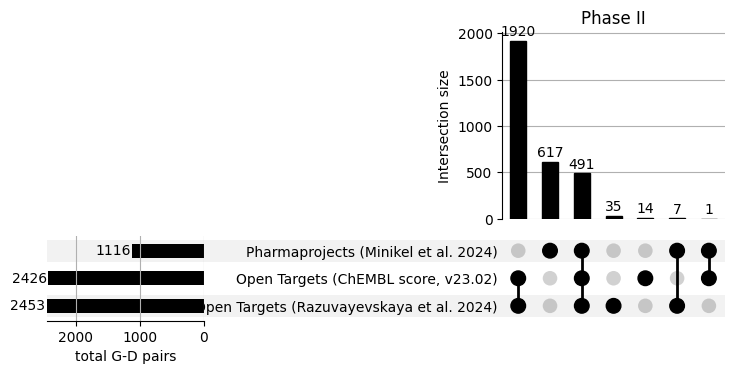

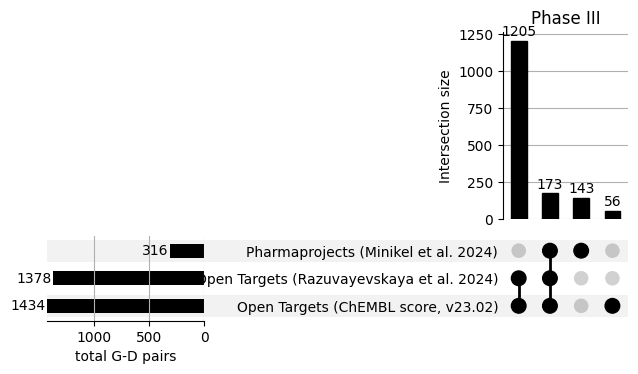

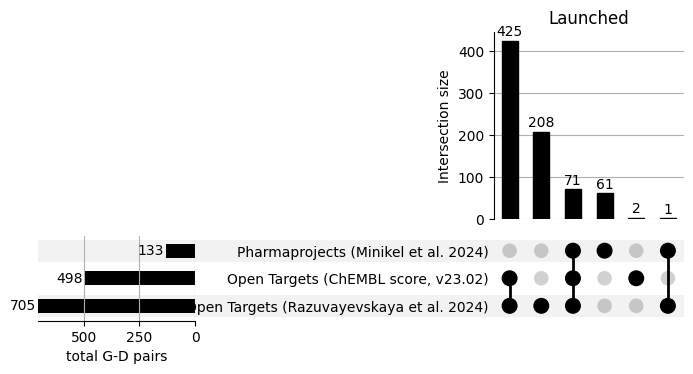

In [349]:
minikel_targets_df['gd_pair'] = minikel_targets_df['gene_id'].astype(str) + '-' + minikel_targets_df['disease_ontology_id'].astype(str)
ot2024_targets_df['gd_pair'] = ot2024_targets_df['gene_id'].astype(str) + '-' + ot2024_targets_df['disease_ontology_id'].astype(str)
otV1_targets_df['gd_pair'] = otV1_targets_df['gene_id'].astype(str) + '-' + otV1_targets_df['disease_ontology_id'].astype(str)

# compare_gd_tables = pd.DataFrame()
targets_df_dict = {'Pharmaprojects (Minikel et al. 2024)':minikel_targets_df, 'Open Targets (Razuvayevskaya et al. 2024)':ot2024_targets_df, 'Open Targets (ChEMBL score, v23.02)':otV1_targets_df}

for s_col in success_cols[1:]:
    upset_dict = {}
    for k,t in targets_df_dict.items():
        targets_df = t[['gd_pair', s_col]].copy()
        targets_df = targets_df[targets_df[s_col] == 1]
        upset_dict[k] = targets_df.gd_pair.unique()

    target_universe_upset = upsetplot.from_contents(upset_dict)

    with plt.rc_context({'figure.figsize':[10,10]}):
        pl = upsetplot.UpSet(
            target_universe_upset, 
            orientation='horizontal', 
            show_counts = '{:d}', 
            sort_categories_by='cardinality',
            sort_by='cardinality',
            element_size=30,
            totals_plot_elements=5
        )
        plt_res = pl.plot()
        plt_res["totals"].set_xlabel("total G-D pairs")
        plt.title(succ2maxphase[s_col]);
        plt.savefig(figdir + f'upset_gd_source_{s_col}.pdf')

## Check reasons for stopping

In [570]:
ot2024_targets_df_full.to_csv('../data/OT2024_reasons2stop.csv')

In [28]:
ot2024_targets_df_full = pd.read_csv('../data/OT2024_reasons2stop.csv')

/tmp/ipykernel_280/2237542852.py:1: DtypeWarning: Columns (22,23,24,25,26,31) have mixed types. Specify dtype option on import or set low_memory=False.
  ot2024_targets_df_full = pd.read_csv('../data/OT2024_reasons2stop.csv')


In [445]:
stop_3_evidence_df = pd.merge(evidence_table, nelson_targets_df, how='left')
stop_3_evidence_df = stop_3_evidence_df[~stop_3_evidence_df['succ_3_a'].isna()]

To share with Rasa

In [430]:
ot2024_targets_df_full

,Unnamed: 0,targetId,diseaseId,nctid,clinicalStatus,clinicalPhase,studyStartDate,stopStatus,isStopped,phase4,...,taLabel,taLabelSimple,gc,lof_tolerance,rnaDistribution,rnaSpecificity,partnersBin,datasourceId,datatypeId,total
0,0,ENSG00000004468,EFO_0000203,NCT03236428,"Active, not recruiting",2,2017-11-24,NaN,NaN,NaN,...,hematologic disease,Other,3.0,LoF tolerant,Detected in many,Tissue enhanced,none,chembl,known_drug,413311
1,1,ENSG00000004468,EFO_0000203,NCT03236428,"Active, not recruiting",2,2017-11-24,NaN,NaN,NaN,...,hematologic disease,Other,3.0,LoF tolerant,Detected in many,Tissue enhanced,none,europepmc,literature,413311
2,2,ENSG00000004468,EFO_0000203,NCT03236428,"Active, not recruiting",2,2017-11-24,NaN,NaN,NaN,...,hematologic disease,Other,NaN,LoF tolerant,Detected in many,Tissue enhanced,none,chembl,known_drug,413311
3,3,ENSG00000004468,EFO_0000203,NCT03236428,"Active, not recruiting",2,2017-11-24,NaN,NaN,NaN,...,hematologic disease,Other,NaN,LoF tolerant,Detected in many,Tissue enhanced,none,europepmc,literature,413311
4,4,ENSG00000004468,EFO_0000203,NCT03236428,"Active, not recruiting",2,2017-11-24,NaN,NaN,NaN,...,hematologic disease,Other,NaN,LoF tolerant,Detected in many,Tissue enhanced,none,chembl,known_drug,413311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2778287,2778287,ENSG00000278195,MONDO_0008315,NCT00510224,Terminated,2,2007-07-01,Terminated,stopped,NaN,...,cell proliferation disorder,Oncology,NaN,NaN,Detected in some,Tissue enhanced,from1to10,chembl,known_drug,413311
2778288,2778288,ENSG00000278195,MONDO_0008315,NCT00510224,Terminated,2,2007-07-01,Terminated,stopped,NaN,...,cell proliferation disorder,Oncology,NaN,NaN,Detected in some,Tissue enhanced,from1to10,slapenrich,affected_pathway,413311
2778289,2778289,ENSG00000278195,MONDO_0008315,NCT00166725,Completed,2,2004-02-01,NaN,NaN,NaN,...,cell proliferation disorder,Oncology,NaN,NaN,Detected in some,Tissue enhanced,from1to10,chembl,known_drug,413311
2778290,2778290,ENSG00000278195,MONDO_0008315,NCT00166725,Completed,2,2004-02-01,NaN,NaN,NaN,...,cell proliferation disorder,Oncology,NaN,NaN,Detected in some,Tissue enhanced,from1to10,slapenrich,affected_pathway,413311


In [442]:
success_cols = ['succ_p_1', 'succ_1_2', 'succ_2_3', 'succ_3_a']
stop_reasons_df = ot2024_targets_df_full.rename({'targetId':'gene_id', 'diseaseId':'disease_ontology_id', 'phase2':'succ_1_2', 'phase3':'succ_2_3', 'phase4':'succ_3_a'}, axis=1)
ot_efo_to_keep = [mondo2efo[x] for x in evidence_table.disease_ontology_id.unique()]
stop_reasons_df = stop_reasons_df[stop_reasons_df['disease_ontology_id'].isin(ot_efo_to_keep)]

# Rename disease_ontology_id
stop_reasons_df['disease_ontology_id'] = [efo2mondo[x] for x in stop_reasons_df['disease_ontology_id']]
stop_reasons_df = stop_reasons_df[['gene_id', 'disease_ontology_id', 'prediction', 'why_stopped', 'nctid', 'clinicalPhase', 'isStopped', 'status']].drop_duplicates()

In [446]:
stop_3_evidence_df = pd.merge(stop_3_evidence_df, stop_reasons_df, how='left', on = ['disease_ontology_id', 'gene_id'])

In [457]:
stop_3_evidence_df[(stop_3_evidence_df['succ_3_a']==False) & (stop_3_evidence_df['disease_evidence']==1) & (~stop_3_evidence_df['prediction'].isna())]

,gene_id,gene_name,disease,disease_ontology_id,ct_marker_evidence,disease_evidence,disease_ct_evidence,bulk_disease_evidence,genetic_evidence_OT,is_hvg_normal,...,succ_3_a,target_status,MONDO,genetic_evidence_minikel,prediction,why_stopped,nctid,clinicalPhase,isStopped,status
81,ENSG00000173585,CCR9,Crohn disease,MONDO_0005011,1.0,1.0,1.0,0.0,0.0,1.0,...,False,unsupported target,NaN,0.0,Negative,This study was terminated due to the lack of e...,NCT01318993,3.0,stopped,Terminated
82,ENSG00000173585,CCR9,Crohn disease,MONDO_0005011,1.0,1.0,1.0,0.0,0.0,1.0,...,False,unsupported target,NaN,0.0,Negative,This study was terminated due to the lack of e...,NCT01316939,3.0,stopped,Terminated
210,ENSG00000171105,INSR,myocardial infarction,MONDO_0005068,0.0,1.0,0.0,1.0,0.0,1.0,...,False,unsupported target,MONDO_0005068,0.0,Insufficient_Enrollment,Due to Negative feasibility assessment of recr...,NCT00670228,3.0,stopped,Terminated
528,ENSG00000111537,IFNG,COVID-19,MONDO_0100096,1.0,1.0,1.0,0.0,0.0,1.0,...,False,unsupported target,NaN,0.0,Study_Design,Standard of care evolved during the timeframe ...,NCT04324021,2.0,stopped,Terminated
529,ENSG00000111537,IFNG,COVID-19,MONDO_0100096,1.0,1.0,1.0,0.0,0.0,1.0,...,False,unsupported target,NaN,0.0,Insufficient_Enrollment,Standard of care evolved during the timeframe ...,NCT04324021,2.0,stopped,Terminated
531,ENSG00000122194,PLG,COVID-19,MONDO_0100096,0.0,1.0,0.0,1.0,0.0,0.0,...,False,unsupported target,NaN,0.0,Logistics_Resources,"Due to ongoing vaccination efforts, feasibilit...",NCT04338126,2.0,stopped,Withdrawn
532,ENSG00000122194,PLG,COVID-19,MONDO_0100096,0.0,1.0,0.0,1.0,0.0,0.0,...,False,unsupported target,NaN,0.0,Insufficient_Enrollment,"Due to ongoing vaccination efforts, feasibilit...",NCT04338126,2.0,stopped,Withdrawn
534,ENSG00000122194,PLG,COVID-19,MONDO_0100096,0.0,1.0,0.0,1.0,0.0,0.0,...,False,unsupported target,NaN,0.0,Insufficient_Enrollment,"With vaccination efforts ongoing, a feasibilit...",NCT04550338,3.0,stopped,Withdrawn
535,ENSG00000122194,PLG,COVID-19,MONDO_0100096,0.0,1.0,0.0,1.0,0.0,0.0,...,False,unsupported target,NaN,0.0,Insufficient_Enrollment,Lack of recruitment,NCT04338074,2.0,stopped,Terminated


In [439]:
stop_3_evidence_df.drop(['disease_ct_evidence','bulk_disease_evidence','is_hvg_normal','is_hvg_disease'], axis=1).to_csv('../data/evidence_reasons2stop.csv')

There can be many trials for the same G-D pair

In [249]:
stop_3_evidence_df[(stop_3_evidence_df['disease_ontology_id'] == 'MONDO_0005011') & (stop_3_evidence_df['gene_id'] == 'ENSG00000173585')]

,gene_id,gene_name,disease,disease_ontology_id,ct_marker_evidence,disease_evidence,disease_ct_evidence,bulk_disease_evidence,genetic_evidence_OT,is_hvg_normal,is_hvg_disease,prediction,why_stopped,nctid,phase,isStopped,succ_1_2,succ_2_3,succ_3_a
58636,ENSG00000173585,CCR9,Crohn disease,MONDO_0005011,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,NCT01536418,NaN,stopped,Phase II+,Phase III+,NaN
58637,ENSG00000173585,CCR9,Crohn disease,MONDO_0005011,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,NCT01611805,NaN,NaN,NaN,NaN,NaN
58638,ENSG00000173585,CCR9,Crohn disease,MONDO_0005011,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,NCT00102921,NaN,NaN,Phase II+,NaN,NaN
58639,ENSG00000173585,CCR9,Crohn disease,MONDO_0005011,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,NCT01277666,NaN,NaN,Phase II+,Phase III+,NaN
58640,ENSG00000173585,CCR9,Crohn disease,MONDO_0005011,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,NCT00306215,NaN,NaN,Phase II+,NaN,NaN
58641,ENSG00000173585,CCR9,Crohn disease,MONDO_0005011,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,NCT01489943,NaN,NaN,NaN,NaN,NaN
58642,ENSG00000173585,CCR9,Crohn disease,MONDO_0005011,1.0,1.0,1.0,0.0,0.0,1.0,1.0,Negative,This study was terminated due to the lack of e...,NCT01318993,Phase 3,stopped,Phase II+,Phase III+,NaN
58643,ENSG00000173585,CCR9,Crohn disease,MONDO_0005011,1.0,1.0,1.0,0.0,0.0,1.0,1.0,Negative,This study was terminated due to the lack of e...,NCT01316939,Phase 3,stopped,Phase II+,Phase III+,NaN
58644,ENSG00000173585,CCR9,Crohn disease,MONDO_0005011,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,NCT01827631,NaN,NaN,NaN,NaN,NaN
58645,ENSG00000173585,CCR9,Crohn disease,MONDO_0005011,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,NCT01114607,NaN,NaN,NaN,NaN,NaN


How many phase III failures supported per disease

In [413]:
pl_df = stop_3_evidence_df[(stop_3_evidence_df['clinicalPhase'] == 3) & (stop_3_evidence_df['isStopped'] == 'stopped')][
    ['prediction', 'ct_marker_evidence','disease_evidence', 'disease', 'gene_id', 'nctid']
]

# Number of cell type specific
size_df = pl_df.groupby(['prediction'])[['ct_marker_evidence', 'disease_evidence']].sum().reset_index()
size_all_df = pl_df.groupby(['prediction'])[['ct_marker_evidence', 'disease_evidence']].size().reset_index()
# size_df.columns = ['disease', 'prediction', 'n_ct_marker_evidence']
n_genes_df = pl_df[pl_df['ct_marker_evidence'] == 1].groupby(['prediction'])['gene_id'].nunique().reset_index()
size_df = pd.merge(size_df, n_genes_df)
size_df = pd.merge(size_df, size_all_df).rename({0:'total_failures'}, axis=1)
size_df.sort_values('total_failures')

,prediction,ct_marker_evidence,disease_evidence,gene_id,total_failures
9,Safety_Sideeffects,4.0,4.0,2,8
2,Covid19,7.0,4.0,3,15
5,Logistics_Resources,2.0,7.0,2,17
4,Invalid_Reason,8.0,8.0,5,34
0,Another_Study,1.0,6.0,1,35
8,Regulatory,13.0,9.0,5,42
7,No_Context,2.0,6.0,2,52
10,Study_Design,11.0,14.0,5,85
6,Negative,31.0,29.0,14,137
1,Business_Administrative,36.0,50.0,22,188


In [417]:
%%R -i size_df -w 1000 -i figdir
size_df %>%
    arrange(total_failures) %>%
    mutate(prediction = factor(prediction, levels=unique(prediction))) %>%
    ggplot( aes(prediction, total_failures/sum(total_failures)) )+
    geom_point(size=5, aes(color='all')) +
    geom_point(aes(y=ct_marker_evidence/sum(ct_marker_evidence), color='cell type specific'), size=5, shape=2) +
    geom_point(aes(y=disease_evidence/sum(disease_evidence), color='disease cell specific'), size=5, shape=3) +
#     geom_col(aes(y=disease_evidence), fill='blue') +
scale_color_manual(values=c(all='grey','cell type specific'='red','disease cell specific'= 'blue' ), name='G-D pair type') +
    ylab('Fraction of stopped trials') +
    xlab('Predicted trial stop reason') +
    theme_classic(base_size=24) +
    coord_flip() 

ggsave(paste0(figdir, 'reason2stop_phase3.pdf'), width=10, height=5)
ggsave(paste0(figdir, 'reason2stop_phase3.png'), width=10, height=5)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [462]:
size_df[size_df['prediction'].isin(['Business_Administrative'])]['total_failures'].sum()/size_df['total_failures'].sum()

0.214123006833713

In [461]:
size_df[size_df['prediction'].isin(['Business_Administrative'])]['disease_evidence'].sum()/size_df['disease_evidence'].sum()

0.2717391304347826

In [460]:
pl_df.prediction.unique()

array(['Safety_Sideeffects', 'Another_Study', 'Negative',
       'Insufficient_Enrollment', 'Business_Administrative', nan,
       'Logistics_Resources', 'Regulatory', 'No_Context',
       'Invalid_Reason', 'Study_Design', 'Covid19'], dtype=object)

In [424]:
size_df[size_df['prediction'].isin(['Negative', 'Safety_Sideeffects'])]['ct_marker_evidence'].sum()/size_df['ct_marker_evidence'].sum()

0.24822695035460993

## Impact of size of single cell cohort

In [368]:
# Get number of tested targets x disease
def _ndonors_DE(
    disease_ontology_id, 
    data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
    ):
    pbulk_adata = sc.read_h5ad(data_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_genes.h5ad', backed=True)
    count_donors = pbulk_adata.obs[['disease', 'donor_id']].drop_duplicates().value_counts('disease')
    n_normal, n_disease = count_donors['normal'], count_donors[count_donors.index != 'normal'][0]
    n_normal_cells = pbulk_adata[pbulk_adata.obs['disease'] == 'normal'].obs['n_cells'].sum()
    n_disease_cells = pbulk_adata[pbulk_adata.obs['disease'] != 'normal'].obs['n_cells'].sum()
    mean_cells_disease_donor = pbulk_adata[pbulk_adata.obs['disease'] != 'normal'].obs[['n_cells','donor_id']].groupby('donor_id').sum().mean()[0]
    return(n_normal, n_disease, n_normal_cells, n_disease_cells, mean_cells_disease_donor)

In [369]:
targets_evidence_all['n_normal_donors'] = np.nan
targets_evidence_all['n_disease_donors'] = np.nan

for disease_ontology_id in targets_evidence_all.disease_ontology_id.unique():
    try:
        n_normal, n_disease, n_normal_cells, n_disease_cells,mean_cells_disease_donor = _ndonors_DE(disease_ontology_id)
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'n_normal_donors'] = n_normal
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'n_disease_donors'] = n_disease
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'n_disease_cells'] = n_disease_cells
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'n_normal_cells'] = n_normal_cells
        targets_evidence_all.loc[targets_evidence_all.disease_ontology_id == disease_ontology_id, 'mean_cells_disease_donor'] = mean_cells_disease_donor
        
    except FileNotFoundError:
        print(f'missing {disease_ontology_id}')
        continue
    except RuntimeError:
        print(f'missing {disease_ontology_id}')
        continue

In [373]:
n_donors_by_disease = evidence_table.groupby('disease_ontology_id').sum()[['ct_marker_evidence', 'disease_evidence']].reset_index()
n_donors_by_disease = pd.merge(n_donors_by_disease, targets_evidence_all[['n_normal_donors', 'n_disease_donors','n_disease_cells', 'n_normal_cells', 'disease_ontology_id', 'mean_cells_disease_donor']].drop_duplicates())

/tmp/ipykernel_257/1728215847.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_donors_by_disease = evidence_table.groupby('disease_ontology_id').sum()[['ct_marker_evidence', 'disease_evidence']].reset_index()


In [381]:
results_bydisease_df = pd.merge(results_bydisease_df, all_diseases, how='left')

In [382]:
data = pd.merge(results_bydisease_df, n_donors_by_disease)
# sns.scatterplot(x=np.log10(data['n_normal_donors']), y=np.log(data['odds_ratio']));
# plt.show()

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


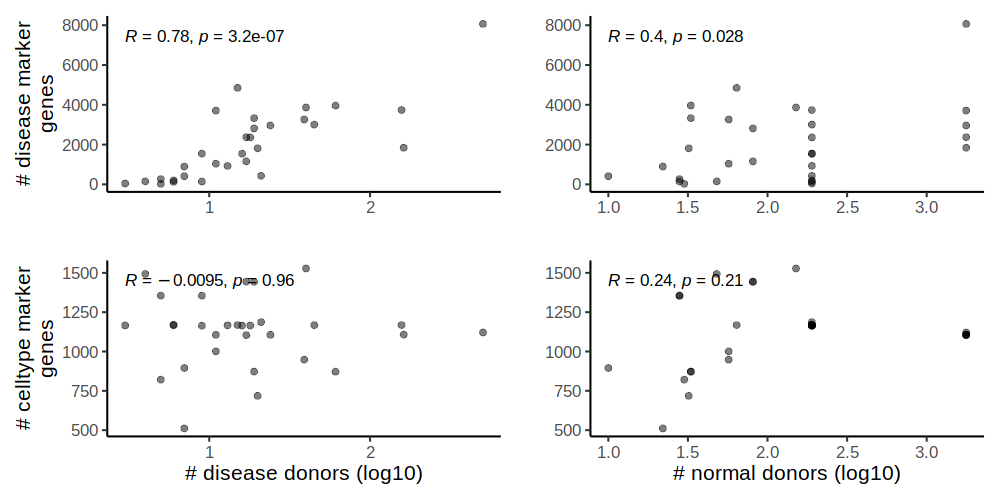

In [385]:
%%R -i n_donors_by_disease -w 1000 -h 500
pl1 <- n_donors_by_disease %>%
ggplot(aes(log10(n_disease_donors), disease_evidence)) +
geom_point(size=3, alpha=0.5) +
theme_classic(base_size=21) +
ylab('# disease marker\ngenes') +
xlab('') +
ggpubr::stat_cor(size=6)
pl2 <- n_donors_by_disease %>%
ggplot(aes(log10(n_normal_donors), disease_evidence)) +
geom_point(size=3, alpha=0.5) +
theme_classic(base_size=21) +
ylab('') +
xlab('') +
ggpubr::stat_cor(size=6)
pl3 <- n_donors_by_disease %>%
ggplot(aes(log10(n_disease_donors), ct_marker_evidence)) +
geom_point(size=3, alpha=0.5) +
theme_classic(base_size=21) +
ylab('# celltype marker\ngenes') +
xlab('# disease donors (log10)') +
ggpubr::stat_cor(size=6)
pl4 <- n_donors_by_disease %>%
ggplot(aes(log10(n_normal_donors), ct_marker_evidence)) +
geom_point(size=3, alpha=0.5) +
theme_classic(base_size=21) +
ylab('') +
xlab('# normal donors (log10)') +
ggpubr::stat_cor(size=6)

pl_b <- (pl1 | pl2) / (pl3 | pl4) 
# ggsave_figdir('no_markers_vs_donors', width=15, height=10)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


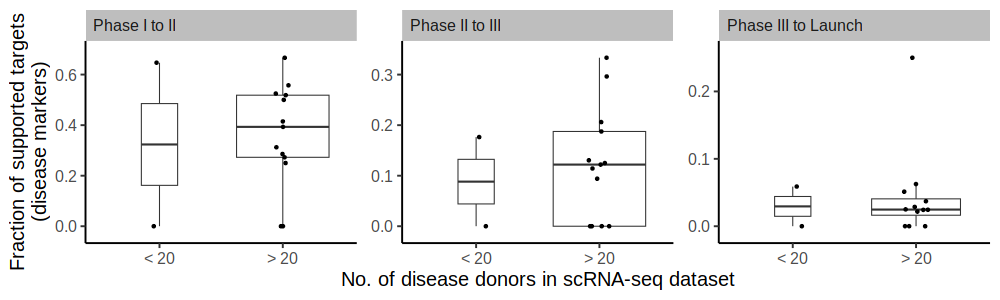

In [473]:
%%R -i data -w 1000 -h 300

pl_c <- data %>%
    filter(evidence == 'Disease cell specific') %>%
    arrange(n_normal_donors) %>%
    # filter(disease != 'pulmonary emphysema') %>%
    mutate(disease = factor(disease, levels=unique(disease))) %>%
#     mutate(clinical_status = factor(str_remove(clinical_status, 'is_'), levels=(c('druggable', 'safe', 'effective', 'approved')))) %>%
#     mutate(n_disease_donors_bin = cut(n_disease_donors, breaks=c(0,10, 30,1000), 
#                                       labels=c('30', '>30')
#                                      )
#           ) %>%
    mutate(n_disease_donors_bin = ifelse(n_disease_donors <= 50, '< 20', '> 20')) %>%
    ggplot(aes(
        n_disease_donors_bin,
        n_supported_approved/n_supported
              )) +
    geom_boxplot(varwidth=TRUE, outlier.alpha=0) +
    geom_jitter(width=0.1) +
    xlab('No. of disease donors in scRNA-seq dataset') +
    ylab('Fraction of supported targets\n(disease markers)') +
    facet_wrap(clinical_status~., scales='free') +
    theme_classic(base_size=20) + 
    scale_y_continuous(expand=expansion(mult = c(0.1, .1))) +
    theme(strip.text = element_text(hjust = 0), strip.background=element_rect(color=NA, fill='grey'),
                                        panel.spacing=unit(1,"lines")
                                       )
pl_c

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


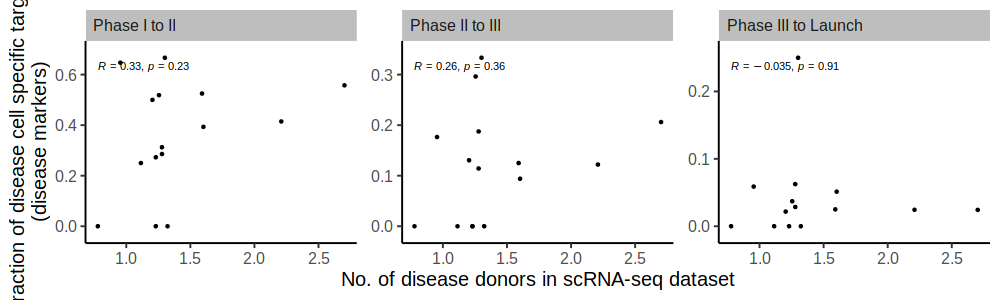

In [467]:
%%R -i data -w 1000 -h 300
my_comparisons <- list( c('3-10', "10-100"))

pl_c <- data %>%
    filter(evidence == 'Disease cell specific') %>%
    arrange(n_disease_donors/n_normal_donors) %>%
    mutate(disease = factor(disease, levels=unique(disease))) %>%
    mutate(n_disease_donors_bin = ifelse(n_disease_donors <= 20, '< 10', '> 10')) %>%
    ggplot(aes(
        log10(n_disease_donors),
        n_supported_approved/n_supported
              )) +
#     scale_x_log10() +
    geom_point(width=0.1) +
    xlab('No. of disease donors in scRNA-seq dataset') +
    ylab('Fraction of disease cell specific targets\n(disease markers)') +
    ggpubr::stat_cor() +
#     ggpubr::stat_compare_means(comparisons = my_comparisons, size=5, method='wilcox.test', format='p.format', ) +
    facet_wrap(clinical_status~., scales='free') +
    theme_classic(base_size=20) + 
    scale_y_continuous(expand=expansion(mult = c(0.1, .1))) +
    theme(strip.text = element_text(hjust = 0), strip.background=element_rect(color=NA, fill='grey'),
                                        panel.spacing=unit(1,"lines")
                                       )
pl_c